Evaluation Results: {'Linear Regression': {'mse': 0.09699347940701311}, 'Polynomial Regression': {'mse': 0.6662569668966198}, 'Lasso Regression': {'mse': 0.11836697134099741}, 'Logistic Regression': {'accuracy': 0.9, 'precision': 0.9181818181818182, 'recall': 0.9, 'f1_score': 0.9}}


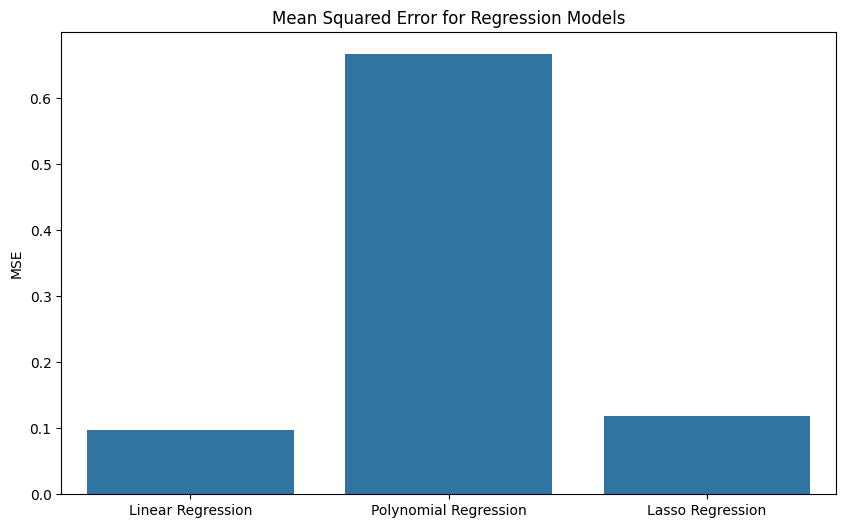

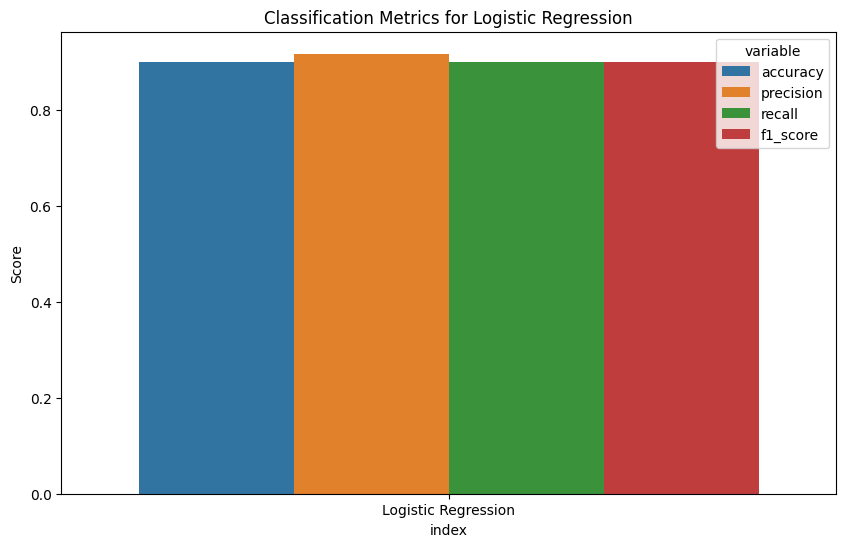

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import (
    mean_squared_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)


# Load and preprocess the dataset
def load_and_preprocess_data(sample_size=100):
    newsgroups = fetch_20newsgroups(subset="all", categories=["sci.space", "sci.med"])
    data = newsgroups.data[:sample_size]
    target = newsgroups.target[:sample_size]

    vectorizer = TfidfVectorizer(max_features=300)  # Reduced number of features
    features = vectorizer.fit_transform(data).toarray()

    return features, target, newsgroups


# Feature Engineering
def feature_engineering(features, target):
    # Feature Scaling
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Feature Selection using Lasso for feature importance
    lasso = Lasso(alpha=0.1)
    lasso.fit(features_scaled, target)
    selector = SelectFromModel(lasso, threshold="mean", prefit=True)
    features_selected = selector.transform(features_scaled)

    # Dimensionality Reduction
    n_components = min(20, features_selected.shape[1])  # Ensure components <= features
    pca = PCA(n_components=n_components)
    features_reduced = pca.fit_transform(features_selected)

    return features_reduced


# Model Implementation
def implement_regression_models(features, target):
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=42
    )

    # Linear Regression
    linreg_model = LinearRegression()
    linreg_model.fit(X_train, y_train)
    linreg_pred = linreg_model.predict(X_test)

    # Polynomial Regression
    poly = PolynomialFeatures(degree=2)
    poly_model = make_pipeline(poly, LinearRegression())
    poly_model.fit(X_train, y_train)
    poly_pred = poly_model.predict(X_test)

    # Lasso Regression
    lasso_model = Lasso(alpha=0.1)
    lasso_model.fit(X_train, y_train)
    lasso_pred = lasso_model.predict(X_test)

    # Logistic Regression
    logreg_model = LogisticRegression(max_iter=1000)
    logreg_model.fit(X_train, y_train)
    logreg_pred = logreg_model.predict(X_test)

    return (linreg_pred, poly_pred, lasso_pred, logreg_pred, y_test)


# Model Evaluation
def evaluate_models(linreg_pred, poly_pred, lasso_pred, logreg_pred, y_test):
    results = {}

    results["Linear Regression"] = {"mse": mean_squared_error(y_test, linreg_pred)}

    results["Polynomial Regression"] = {"mse": mean_squared_error(y_test, poly_pred)}

    results["Lasso Regression"] = {"mse": mean_squared_error(y_test, lasso_pred)}

    results["Logistic Regression"] = {
        "accuracy": accuracy_score(y_test, logreg_pred),
        "precision": precision_score(y_test, logreg_pred, average="weighted"),
        "recall": recall_score(y_test, logreg_pred, average="weighted"),
        "f1_score": f1_score(y_test, logreg_pred, average="weighted"),
    }

    return results


# Visualizations
def plot_results(results):
    # Plotting MSE for regression models
    regression_results = {
        key: value["mse"] for key, value in results.items() if "mse" in value
    }
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(regression_results.keys()), y=list(regression_results.values()))
    plt.title("Mean Squared Error for Regression Models")
    plt.ylabel("MSE")
    plt.show()

    # Plotting classification metrics for logistic regression
    classification_results = {
        key: value for key, value in results.items() if "accuracy" in value
    }
    classification_df = pd.DataFrame(classification_results).T.reset_index()
    classification_df = classification_df.melt(
        id_vars="index", value_vars=["accuracy", "precision", "recall", "f1_score"]
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(data=classification_df, x="index", y="value", hue="variable")
    plt.title("Classification Metrics for Logistic Regression")
    plt.ylabel("Score")
    plt.show()


# Main Program
features, target, newsgroups = load_and_preprocess_data(sample_size=100)
features_reduced = feature_engineering(features, target)
linreg_pred, poly_pred, lasso_pred, logreg_pred, y_test = implement_regression_models(
    features_reduced, target
)
results = evaluate_models(linreg_pred, poly_pred, lasso_pred, logreg_pred, y_test)

print(f"Evaluation Results: {results}")
plot_results(results)